In [8]:
#https://storage.cloud.google.com/dynamic_pricing-data/merged_dynamic_pricing_data.csv

import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning


import pandas as pd
import holidays
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from darts import TimeSeries
from darts.models import XGBModel


warnings.filterwarnings("ignore", message=".The 'nopython' keyword.")
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

feature_sku_data=pd.read_csv("merged_dynamic_pricing_data.csv")
# print(feature_sku_data)
feature_sku_data = feature_sku_data[[
    'Creation_Date', 'Product_Item_Sku_Id', 'Base_Price', 'Quantity','listPrice','salePrice','msrp','views','cart_quantity']]


feature_sku_data['Creation_Date'] = pd.to_datetime(feature_sku_data['Creation_Date'])
feature_sku_data['Creation_Date'] = feature_sku_data['Creation_Date'].dt.date
feature_sku_data.set_index('Creation_Date', inplace=True)
feature_sku_data.sort_index(ascending=True, inplace=True)
feature_sku_data.index = pd.to_datetime(feature_sku_data.index)



feature_daily_base_price = feature_sku_data['Base_Price'].resample(
        'D').mean()
feature_daily_base_price_df = pd.DataFrame(
    {'Base_Price': feature_daily_base_price})
feature_daily_base_price_df['Base_Price'].fillna(
    method='ffill', inplace=True)

feature_daily_quantity_sum = pd.Series(
    feature_sku_data['Quantity'].resample('D').sum())
feature_daily_quantity_df = pd.DataFrame(
    {'Quantity': feature_daily_quantity_sum})


feature_daily_list_price = feature_sku_data['listPrice'].resample(
    'D').mean()
feature_daily_list_price_df = pd.DataFrame(
    {'listPrice': feature_daily_list_price})
feature_daily_list_price_df['listPrice'].fillna(
    method='ffill', inplace=True)

feature_daily_sale_price = feature_sku_data['salePrice'].resample(
    'D').mean()
feature_daily_sale_price_df = pd.DataFrame(
    {'salePrice': feature_daily_sale_price})

feature_daily_msrp_price = feature_sku_data['msrp'].resample(
    'D').mean()
feature_daily_msrp_price_df = pd.DataFrame(
    {'msrp': feature_daily_msrp_price})
feature_daily_msrp_price_df['msrp'].fillna(
    method='ffill', inplace=True)


feature_daily_views_sum = pd.Series(
    feature_sku_data['views'].resample('D').sum())
feature_daily_views_df = pd.DataFrame(
    {'views': feature_daily_views_sum})


feature_daily_carts_sum = pd.Series(
    feature_sku_data['cart_quantity'].resample('D').sum())
feature_daily_carts_df = pd.DataFrame(
    {'cart_quantity': feature_daily_carts_sum})


# Combine DataFrames
feature_sku_data = pd.DataFrame(
    {'Quantity': feature_daily_quantity_df['Quantity'], 
    'Base_Price': feature_daily_base_price_df['Base_Price'],
    'listPrice': feature_daily_list_price_df['listPrice'],
    'salePrice': feature_daily_sale_price_df['salePrice'],
    'msrp': feature_daily_msrp_price_df['msrp'],
    'views': feature_daily_views_df['views'],
    'cart_quantity': feature_daily_carts_df['cart_quantity'],
    'Product_Item_Sku_Id': feature_sku_data['Product_Item_Sku_Id']
    })


feature_sku_data.drop(columns=['salePrice'],inplace=True)
feature_sku_data.dropna(inplace=True)



feature_sku_data.reset_index(inplace=True)
feature_sku_data['Creation_Date'] = feature_sku_data['Creation_Date'].astype(str)

# feature_sku_data['Creation_Date'] = pd.to_datetime(feature_sku_data['Creation_Date'])

feature_sku_data = feature_sku_data.sort_values(by=['Product_Item_Sku_Id','Creation_Date'])


feature_sku_data.drop_duplicates(inplace=True)

feature_sku_data.reset_index(inplace=True)
feature_sku_data.drop(columns=['index'],inplace=True)






series=TimeSeries.from_group_dataframe(feature_sku_data,group_cols='Product_Item_Sku_Id',time_col='Creation_Date',fill_missing_dates=False,freq='D',value_cols=None)



C:\Users\HP\AppData\Local\Temp\ipykernel_19372\3050043635.py:20: DtypeWarning: Columns (20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_sku_data=pd.read_csv("merged_dynamic_pricing_data.csv")
C:\Users\HP\AppData\Local\Temp\ipykernel_19372\3050043635.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_daily_base_price_df['Base_Price'].fillna(
C:\Users\HP\AppData\Local\Temp\ipykernel_19372\3050043635.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_daily_list_price_df['listPrice'].fillna(
C:\Users\HP\AppData\Local\Temp\ipykernel_19372\3050043635.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_daily_msrp_price_df['msrp'].fillna(


In [9]:
print(series)


[<TimeSeries (DataArray) (Creation_Date: 1141, component: 6, sample: 1)>
array([[[ 37.        ],
        [286.29133333],
        [286.29033333],
        [286.29033333],
        [  0.        ],
        [  0.        ]],

       [[         nan],
        [         nan],
        [         nan],
        [         nan],
        [         nan],
        [         nan]],

       [[         nan],
        [         nan],
        [         nan],
        [         nan],
        [         nan],
        [         nan]],
...
       [[         nan],
        [         nan],
        [         nan],
        [         nan],
        [         nan],
        [         nan]],

       [[         nan],
        [         nan],
        [         nan],
        [         nan],
        [         nan],
        [         nan]],

       [[ 29.        ],
        [613.1552    ],
        [659.0752    ],
        [731.9152    ],
        [  0.        ],
        [511.        ]]])
Coordinates:
  * Creation_Date  (Creation_Date) 

In [5]:

import pandas as pd 
import numpy as np
import holidays
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from xgboost import XGBRegressor
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, Dropout
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from utils.py import feature_engineering

c:\Users\HP\Documents\Fyp_experimentation\Darts_Experimentation\utils.py:6: DtypeWarning: Columns (20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_dynamic_pricing_data.csv")
c:\Users\HP\Documents\Fyp_experimentation\Darts_Experimentation\utils.py:151: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_daily_base_price_df['Base_Price'].fillna(
c:\Users\HP\Documents\Fyp_experimentation\Darts_Experimentation\utils.py:164: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_daily_list_price_df['listPrice'].fillna(
c:\Users\HP\Documents\Fyp_experimentation\Darts_Experimentation\utils.py:176: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_daily_msrp_price_

     Creation_Date  Quantity  Base_Price  listPrice  salePrice     msrp  \
0       2020-08-02         1     1299.99    1299.99        NaN  1299.99   
1       2020-08-03         0     1299.99    1299.99        NaN  1299.99   
2       2020-08-04         0     1299.99    1299.99        NaN  1299.99   
3       2020-08-05         0     1299.99    1299.99        NaN  1299.99   
4       2020-08-06         0     1299.99    1299.99        NaN  1299.99   
...            ...       ...         ...        ...        ...      ...   
1151    2023-09-27         0     1299.99    1499.99        NaN  1499.99   
1152    2023-09-28         0     1299.99    1499.99        NaN  1499.99   
1153    2023-09-29         1     1299.99    1499.99    1299.99  1499.99   
1154    2023-09-30         0     1299.99    1499.99        NaN  1499.99   
1155    2023-10-01         1     1299.99    1499.99    1299.99  1499.99   

      views  cart_quantity  is_holiday  Quantity_Rolling_3  ...  \
0       0.0            0.0      

ModuleNotFoundError: No module named 'utils.py'; 'utils' is not a package

In [284]:
print(series[1].components.head())

AttributeError: 'Index' object has no attribute 'head'

In [292]:
model=XGBModel(lags=3,output_chunk_length=3)




In [293]:
model.fit(series)
pred=model.predict(3)
print(pred)

ValueError: Specified series do not share any common times for which features can be created.


ValueError: Specified series do not share any common times for which features can be created.

In [7]:


import pandas as pd
import holidays
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from darts import TimeSeries
from darts.models import XGBModel



furniture_sku_top1_data=feature_engineering("MA-DMDEEQ")
furniture_sku_top1_data.drop(columns=['salePrice'],inplace=True)
# Drop missing values introduced by rolling window and lag operations
furniture_sku_top1_data.dropna(inplace=True)
#furniture_sku_top1_data.dropna(inplace=True)
print(furniture_sku_top1_data)
# Split the data into features (X) and target variable (y)

# Define the split date
last_date = furniture_sku_top1_data['Creation_Date'].max()
# Set the split date as 8 days before the last date
split_date = last_date - pd.DateOffset(days=7)

# Split the data into training and testing sets based on the split date
train_mask = furniture_sku_top1_data['Creation_Date'] < split_date
test_mask = ~train_mask


# Select all columns except the target variable for features
your_feature_columns = furniture_sku_top1_data.columns.difference(['Quantity', 'Creation_Date'])

feature_columns_list = list(your_feature_columns)

# List of columns to drop
columns_to_drop = ['isPromotion','msrp','listPrice','Quantity_Rolling_3', 'Base_Price_Rolling_7', 'Base_Price_Rolling_30', 'Base_Price_Lag_7']

# Remove the specified columns from the list
feature_columns_list = [col for col in feature_columns_list if col not in columns_to_drop]

# Convert the list back to an Index if needed
your_feature_columns = pd.Index(feature_columns_list)


# Create training and testing sets
X_train = furniture_sku_top1_data.loc[train_mask, your_feature_columns]
y_train = furniture_sku_top1_data.loc[train_mask, 'Quantity']

X_test = furniture_sku_top1_data.loc[test_mask, your_feature_columns]
y_test = furniture_sku_top1_data.loc[test_mask, 'Quantity']


y_train = TimeSeries.from_series(y_train.reset_index(drop=True))
X_train=TimeSeries.from_series(X_train.reset_index(drop=True))

y_test = TimeSeries.from_series(y_test.reset_index(drop=True))
X_test=TimeSeries.from_series(X_test.reset_index(drop=True))




c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


NameError: name 'feature_engineering' is not defined

[0.05545704 0.09614293 0.04683119 0.03277627 0.0444968  0.2024515
 0.11185311 0.04021772 0.03881777 0.03757317 0.04216309 0.03295768
 0.         0.04988096 0.00485229 0.06975276 0.09377576]


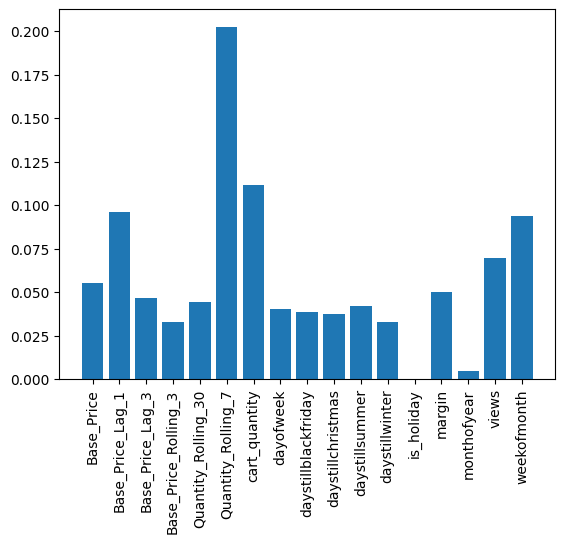

In [ ]:
features = your_feature_columns
pyplot.bar(features, xgb_model.feature_importances_)

# Rotate x-axis labels to 90 degrees
pyplot.xticks(rotation=90)
print(xgb_model.feature_importances_)
pyplot.show()


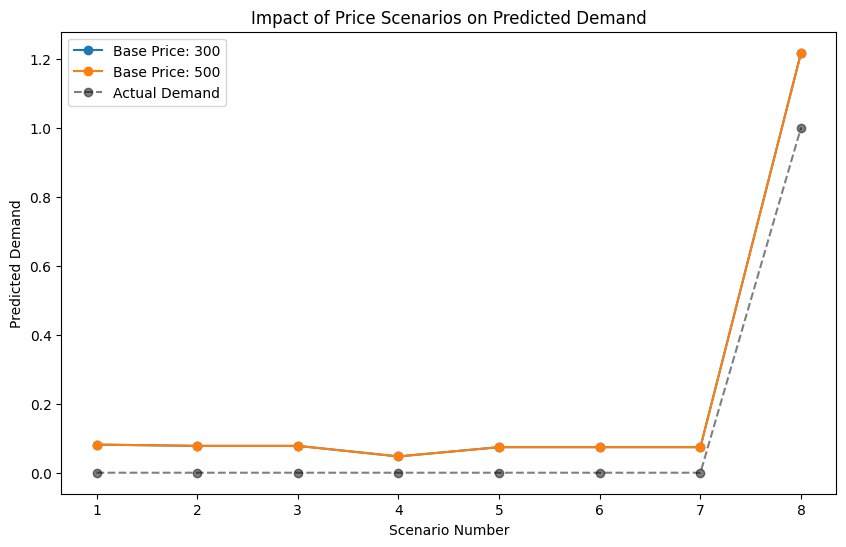

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Define the price scenarios
price_scenarios = [300,500]

# Create a copy of X_test to avoid modifying the original data
X_test_copy = X_test.copy()

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scenarios for predicted demand
for idx, price in enumerate(price_scenarios):
    X_test_copy['Base_Price'] = price
    #print(X_test_copy)
    predicted_demand_scenario = xgb_model.predict(X_test_copy)
    #print(predicted_demand_scenario)
    
    # Plot the line for each scenario
    ax.plot(np.arange(1, 9), predicted_demand_scenario, label=f'Base Price: {price}', marker='o')

# Plot the actual demand for reference
ax.plot(np.arange(1, 9), y_test, label='Actual Demand', color='black', alpha=0.5, linestyle='dashed', marker='o')

# Add labels and legend
ax.set_title('Impact of Price Scenarios on Predicted Demand')
ax.set_xlabel('Scenario Number')
ax.set_ylabel('Predicted Demand')
ax.legend()
plt.show()


In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
}

# Instantiate the XGBoost regressor
xgb_model_hpt = XGBRegressor(objective='reg:squarederror')

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model_hpt, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train an XGBoost model with the best parameters
xgb_model_with_best_params = XGBRegressor(objective='reg:squarederror', **best_params)
xgb_model_with_best_params.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model_with_best_params.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Mean Squared Error: 0.007077548428480511
Root Mean Squared Error: 0.08412816667728182
Mean Absolute Error: 0.07539548259228468


In [ ]:
#Lasso


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the Lasso model
alpha = 0.001  # Adjust the regularization strength
lasso_model = Lasso(alpha=alpha)

# Fit the model on the training data
lasso_model.fit(X_train_scaled, y_train)

# Get selected features
selected_features = your_feature_columns[lasso_model.coef_ != 0]

# Print selected features
print("Selected Features:", selected_features)

# Drop missing values introduced by rolling window and lag operations
furniture_sku_top1_data.dropna(inplace=True)

# Subset the training and testing data using the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train an XGBoost model
xgb_model_lasso = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model_lasso.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = xgb_model_lasso.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


Selected Features: Index(['Base_Price', 'Base_Price_Lag_1', 'Base_Price_Lag_3',
       'Quantity_Rolling_30', 'Quantity_Rolling_7', 'cart_quantity',
       'dayofweek', 'daystillchristmas', 'daystillsummer', 'daystillwinter',
       'is_holiday', 'margin', 'monthofyear', 'views', 'weekofmonth'],
      dtype='object')
Mean Squared Error: 0.0003328299990390961
Root Mean Squared Error: 0.018243628998614723
Mean Absolute Error: 0.01500094195944257


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import pandas as pd
import xgboost as xgb
#Feature Selection with random_forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the Random Forest model
rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': your_feature_columns, 'Importance': feature_importances})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Select features with importance above a certain threshold
threshold = 0.001  # Adjust the threshold as needed
selected_features_rf = feature_importance_df.loc[feature_importance_df['Importance'] > threshold, 'Feature'].tolist()

print(selected_features_rf)

# Subset the training and testing data using the selected features
X_train_selected_rf = X_train[selected_features_rf]
X_test_selected_rf = X_test[selected_features_rf]

# Train an XGBoost model with the selected features
xgb_model_with_random_forest = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model_with_random_forest.fit(X_train_selected_rf, y_train)

# Make predictions on the test set
y_pred_rf = xgb_model_with_random_forest.predict(X_test_selected_rf)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
mae = mean_absolute_error(y_test, y_pred_rf)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


Feature Importances:
                 Feature  Importance
5     Quantity_Rolling_7    0.251748
10        daystillsummer    0.085166
7              dayofweek    0.084884
4    Quantity_Rolling_30    0.081696
9      daystillchristmas    0.074620
6          cart_quantity    0.073996
8    daystillblackfriday    0.064646
11        daystillwinter    0.062739
16           weekofmonth    0.046851
13                margin    0.044435
3   Base_Price_Rolling_3    0.039392
1       Base_Price_Lag_1    0.024331
0             Base_Price    0.019883
2       Base_Price_Lag_3    0.016891
15                 views    0.012304
14           monthofyear    0.011331
12            is_holiday    0.005086
['Quantity_Rolling_7', 'daystillsummer', 'dayofweek', 'Quantity_Rolling_30', 'daystillchristmas', 'cart_quantity', 'daystillblackfriday', 'daystillwinter', 'weekofmonth', 'margin', 'Base_Price_Rolling_3', 'Base_Price_Lag_1', 'Base_Price', 'Base_Price_Lag_3', 'views', 'monthofyear', 'is_holiday']
Mean Squared Err

In [ ]:
import pandas as pd
import holidays
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Drop missing values introduced by rolling window and lag operations
furniture_sku_top1_data.dropna(inplace=True)

last_date = furniture_sku_top1_data['Creation_Date'].max()
# Set the split date as 8 days before the last date
split_date = last_date - pd.DateOffset(days=7)

# Split the data into training and testing sets based on the split date
train_mask = furniture_sku_top1_data['Creation_Date'] < split_date
test_mask = ~train_mask

# Select all columns except the target variable for features
your_feature_columns = furniture_sku_top1_data.columns.difference(['Quantity', 'Creation_Date'])

feature_columns_list = list(your_feature_columns)

# List of columns to drop
columns_to_drop = ['isPromotion','msrp','listPrice','Quantity_Rolling_3', 'Base_Price_Rolling_7', 'Base_Price_Rolling_30', 'Base_Price_Lag_7']

# Remove the specified columns from the list
feature_columns_list = [col for col in feature_columns_list if col not in columns_to_drop]

# Convert the list back to an Index if needed
your_feature_columns = pd.Index(feature_columns_list)

# Split the data into training and testing sets based on the split date
train_mask = furniture_sku_top1_data['Creation_Date'] < split_date
test_mask = ~train_mask

# Select all columns except the target variable for features
your_feature_columns = furniture_sku_top1_data.columns.difference(['Quantity', 'Creation_Date'])


# Create training and testing sets
X_train = furniture_sku_top1_data.loc[train_mask, your_feature_columns]
y_train = furniture_sku_top1_data.loc[train_mask, 'Quantity']

X_test = furniture_sku_top1_data.loc[test_mask, your_feature_columns]
y_test = furniture_sku_top1_data.loc[test_mask, 'Quantity']

# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train a LightGBM model
params = {
    'objective': 'regression',
    'metric': ["l2", "l1"],  # "l2" corresponds to RMSE, "l1" corresponds to MAE
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'verbose': 1  
}

num_boost_round = 100
lightgbm_model = lgb.train(params, train_data, num_boost_round=num_boost_round, valid_sets=[train_data, test_data])

# Make predictions on the test set
y_pred = lightgbm_model.predict(X_test, num_iteration=lightgbm_model.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {mse**0.5}')
print(f'Mean Absolute Error: {mae}')




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 977, number of used features: 24
[LightGBM] [Info] Start training from score 0.212897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Mean Squared Error: 0.0046055627376217255
Root Mean Squared Error: 0.06786429648660425
Mean Absolute Error: 0.060090052925081


In [ ]:
# SVR Model 

import pandas as pd
import holidays
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Drop missing values introduced by rolling window and lag operations
furniture_sku_top1_data.dropna(inplace=True)

# Define the split date
last_date = furniture_sku_top1_data['Creation_Date'].max()
# Set the split date as 8 days before the last date
split_date = last_date - pd.DateOffset(days=7)

# Split the data into training and testing sets based on the split date
train_mask = furniture_sku_top1_data['Creation_Date'] < split_date
test_mask = ~train_mask

# Select all columns except the target variable for features
your_feature_columns = furniture_sku_top1_data.columns.difference(['Quantity', 'Creation_Date'])

feature_columns_list = list(your_feature_columns)

# List of columns to drop
columns_to_drop = ['isPromotion','msrp','listPrice','Quantity_Rolling_3', 'Base_Price_Rolling_7', 'Base_Price_Rolling_30', 'Base_Price_Lag_7']

# Remove the specified columns from the list
feature_columns_list = [col for col in feature_columns_list if col not in columns_to_drop]

# Convert the list back to an Index if needed
your_feature_columns = pd.Index(feature_columns_list)

# Select all columns except the target variable for features
your_feature_columns = furniture_sku_top1_data.columns.difference(['Quantity', 'Creation_Date'])

# Create training and testing sets
X_train = furniture_sku_top1_data.loc[train_mask, your_feature_columns]
y_train = furniture_sku_top1_data.loc[train_mask, 'Quantity']

X_test = furniture_sku_top1_data.loc[test_mask, your_feature_columns]
y_test = furniture_sku_top1_data.loc[test_mask, 'Quantity']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an SVR model
svr_model = SVR(kernel='linear', C=1.0)
svr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {mse**0.5}')
print(f'Mean Absolute Error: {mae}')




Mean Squared Error: 0.01094856913315572
Root Mean Squared Error: 0.10463541051267358
Mean Absolute Error: 0.08300272084415694


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Drop missing values introduced by rolling window and lag operations
furniture_sku_top1_data.dropna(inplace=True)

split_date = last_date - pd.DateOffset(days=7)

# Split the data into training and testing sets based on the split date
train_mask = furniture_sku_top1_data['Creation_Date'] < split_date
test_mask = ~train_mask

# Select all columns except the target variable for features
your_feature_columns = furniture_sku_top1_data.columns.difference(['Quantity', 'Creation_Date'])

feature_columns_list = list(your_feature_columns)

# List of columns to drop
columns_to_drop = ['isPromotion','msrp','listPrice','Quantity_Rolling_3', 'Base_Price_Rolling_7', 'Base_Price_Rolling_30', 'Base_Price_Lag_7']

# Remove the specified columns from the list
feature_columns_list = [col for col in feature_columns_list if col not in columns_to_drop]

# Convert the list back to an Index if needed
your_feature_columns = pd.Index(feature_columns_list)

# Select all columns except the target variable for features
your_feature_columns = furniture_sku_top1_data.columns.difference(['Quantity', 'Creation_Date'])

# Create training and testing sets
X_train = furniture_sku_top1_data.loc[train_mask, your_feature_columns].values
y_train = furniture_sku_top1_data.loc[train_mask, 'Quantity'].values

X_test = furniture_sku_top1_data.loc[test_mask, your_feature_columns].values
y_test = furniture_sku_top1_data.loc[test_mask, 'Quantity'].values

# Scale the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape the input data for LSTM (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=50, batch_size=32, verbose=1)

# Make predictions on the test set
y_pred_scaled = lstm_model.predict(X_test_reshaped)

# Invert scaling for the predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Invert scaling for the actual values
y_test = scaler_y.inverse_transform(y_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {mse**0.5}')
print(f'Mean Absolute Error: {mae}')



Epoch 1/50
31/31 [==============================] - 4s 5ms/step - loss: 0.9217
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.7421
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.6108
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.5529
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.5245
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.5046
Epoch 7/50
31/31 [==============================] - 0s 5ms/step - loss: 0.4826
Epoch 8/50
31/31 [==============================] - 0s 5ms/step - loss: 0.4705
Epoch 9/50
31/31 [==============================] - 0s 5ms/step - loss: 0.4584
Epoch 10/50
31/31 [==============================] - 0s 5ms/step - loss: 0.4487
Epoch 11/50
31/31 [==============================] - 0s 5ms/step - loss: 0.4507
Epoch 12/50
31/31 [==============================] - 0s 4ms/step - loss: 0.4391
Epoch 13/50
31/31 [==============================